In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from scipy.interpolate import interp1d
from scipy import interpolate

In [2]:
with open("Readout_Noise_Measurement - Copy.csv","r") as f:
    reader=csv.reader(f)
    data=list(reader)
data_arry_readout=np.array(data,dtype=float)
R0=data_arry_readout[0,1:]
with open("saturation_time.csv","r") as f:
    reader=csv.reader(f)
    data=list(reader)
data_arry_integration=np.array(data,dtype=float)
with open("thermal_Noise_Measurement.csv","r") as f:
    reader=csv.reader(f)
    data=list(reader)
data_arry_Dark=np.array(data,dtype=float)
with open("Light_Measurement.csv","r") as f:
    reader=csv.reader(f)
    data=list(reader)
data_arry_Light=np.array(data,dtype=float)

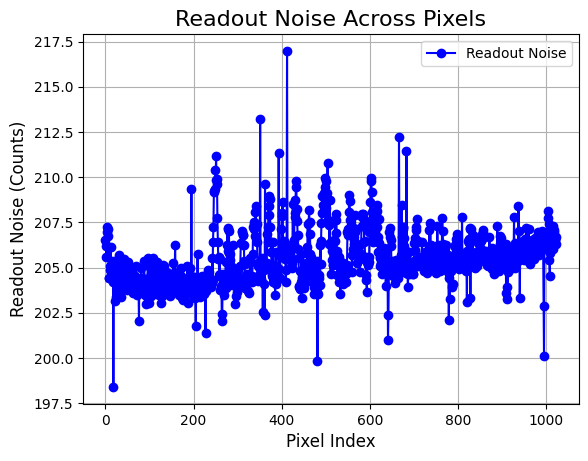

In [3]:

plt.plot(R0, label="Readout Noise", color='blue', linestyle='-', marker='o')
plt.title("Readout Noise Across Pixels", fontsize=16)
plt.xlabel("Pixel Index", fontsize=12)
plt.ylabel("Readout Noise (Counts)", fontsize=12)
plt.legend(loc="best")
plt.grid(True)
plt.show()

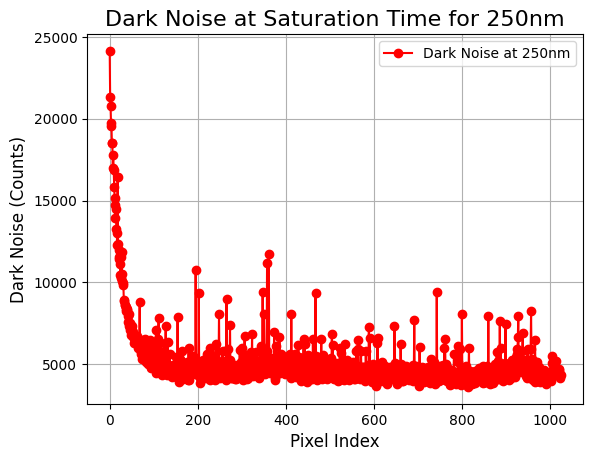

In [4]:
plt.plot(data_arry_Dark[0], label="Dark Noise at 250nm", color='red', linestyle='-', marker='o')
plt.title("Dark Noise at Saturation Time for 250nm", fontsize=16)
plt.xlabel("Pixel Index", fontsize=12)
plt.ylabel("Dark Noise (Counts)", fontsize=12)
plt.legend(loc="best")
plt.grid(True)
plt.show()

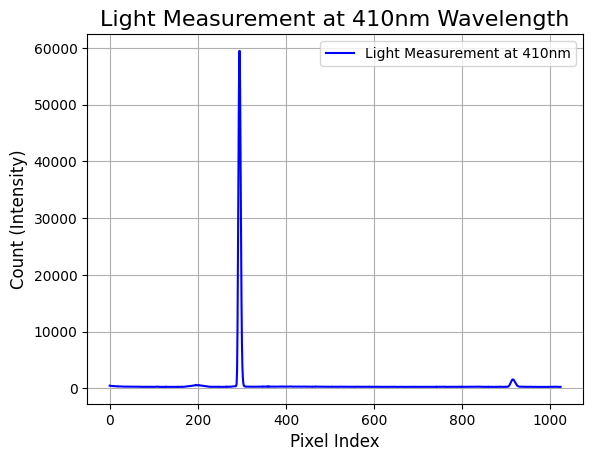

In [5]:

plt.plot(data_arry_Light[20], label="Light Measurement at 410nm", color='blue')
plt.title("Light Measurement at 410nm Wavelength", fontsize=16)
plt.xlabel("Pixel Index", fontsize=12)  
plt.ylabel("Count (Intensity)", fontsize=12)  
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [6]:

max_indices = []
for row in data_arry_Light:
    max_index = np.argmax(row)  
    max_indices.append(max_index)  
print(f"The list of indices of the maximum values in each row: {max_indices}")
j=0
for i in max_indices:
    if i==634:
        print(j)
    j=j+1


The list of indices of the maximum values in each row: [52, 64, 76, 88, 100, 113, 125, 137, 149, 161, 173, 185, 197, 210, 222, 234, 246, 258, 270, 282, 295, 307, 319, 331, 343, 355, 367, 379, 392, 404, 416, 428, 440, 452, 464, 476, 489, 501, 513, 525, 537, 549, 562, 574, 586, 598, 610, 622, 634, 647, 659, 671, 683, 695, 707, 720, 732, 744, 756, 768, 780, 792, 804, 817, 829, 840, 853, 864, 877, 887, 900, 912, 923, 934, 948, 959, 971, 984, 995, 1009, 1018, 1023]
48


In [7]:
LSF= np.zeros((972, 972)) #line spctral function

for i in range(len(data_arry_Light)):
        stray_light_value =  (((data_arry_Light[i] - R0) / data_arry_integration[i]) - ((data_arry_Dark[i] - R0) /data_arry_integration[i]))
        #stray_light_value =  (data_arry_Light[i]/data_arry_integration[i]))
        #stray_light_value=stray_light_value[52:]/np.max(stray_light_value[52:])
        #stray_light_value=stray_light_value[52:]/np.max(stray_light_value[52:])
        stray_light_value=stray_light_value[52:]/(np.max(stray_light_value[52:]))

        #stray_light_value=stray_light_value[52:]
        row_index = max_indices[i]-52
        if 0 <= row_index <= 971:
                LSF[row_index, :] = stray_light_value
        else:
               print(f"Row index {row_index} is out of range for strayLight.")
flattened_strayLight = [item for sublist in LSF for item in sublist if item is not None]
strayLight_array = np.array(flattened_strayLight)
negative_count = np.sum(strayLight_array < 0)
print("Number of negative numbers:", negative_count)
print("all values:", negative_count/len(flattened_strayLight))

Number of negative numbers: 2616
all values: 0.002768886856678352


In [8]:

strayLight_array = np.array(LSF)
strayLight_array[strayLight_array <0] = 0
LSF = strayLight_array.tolist()
flattened_strayLight = [item for sublist in LSF for item in sublist if item is not None]
strayLight_array = np.array(flattened_strayLight)
negative_count = np.sum(strayLight_array < 0)
print("Number of negative numbers:", negative_count)
print("all values:", negative_count/len(flattened_strayLight))

Number of negative numbers: 0
all values: 0.0


In [9]:

def interpolate_all_missing_values(matrix):
    num_cols = matrix.shape[1]
    matrix_copy = matrix.copy()  # Work on a copy to avoid modifying the input directly

    for col in range(num_cols):
        column_data = matrix_copy[:, col]
        
        # Find indices of non-zero values in the column
        non_zero_indices = np.where(column_data != 0)[0]
        
        if len(non_zero_indices) > 1:  # Ensure there's enough data to interpolate
            # Create an interpolation function based on non-zero values
            interp_func = interpolate.interp1d(
                non_zero_indices, 
                column_data[non_zero_indices], 
                kind='linear',
                fill_value="extrapolate"
            )
            
            # Find indices of zero values in the column
            zero_indices = np.where(column_data == 0)[0]

            # Replace zero values with interpolated values
            column_data[zero_indices] = interp_func(zero_indices)
        elif len(non_zero_indices) == 1:
            # If only one non-zero value exists, fill entire column with that value
            matrix_copy[:, col] = column_data[non_zero_indices[0]]
        # If there are no non-zero values, leave the column as is (all zeros)
    
    return matrix_copy

LSF= np.array(LSF)
min_index =0
max_index =971

SDF=interpolate_all_missing_values(LSF)
max_indices = []
# Iterate through each row to find the index of the maximum value
for row in SDF:
    max_index = np.argmax(row)  # Find the index of the maximum value in the row using np.argmax
    max_indices.append(max_index)  # Store the index in the list

# Print the list of indices
print(f"The list of indices of the maximum values in each row: {max_indices}")
#plt.plot(max_indices)

print(np.max(SDF[0]))


The list of indices of the maximum values in each row: [0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 

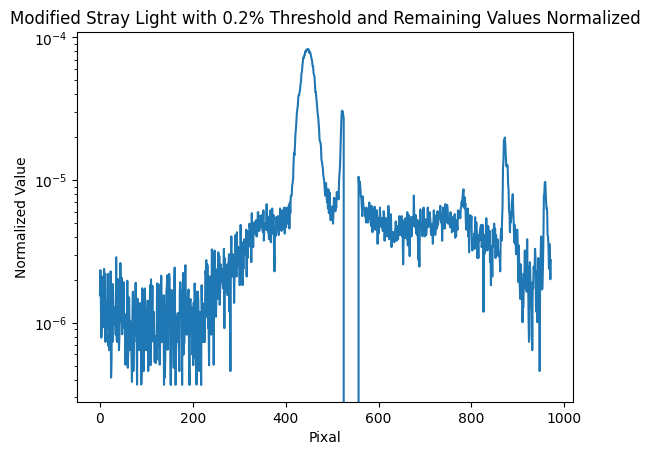

In [10]:


def modify_and_normalize_matrix(matrix, threshold_percentage=50):
    matrix_copy = matrix.copy()
    # Iterate over each row
    for row in range(matrix_copy.shape[0]):
        # Find the index of the maximum value in the current row
        max_index = np.argmax(matrix_copy[row])
        max_value = matrix_copy[row, max_index]
        
        # Calculate the threshold value based on the given percentage
        threshold_value = (threshold_percentage / 100) * max_value
        
        # Initialize left and right indices for the region to zero out
        left_index = max_index
        right_index = max_index
        
        # Search left from the max_index to find the left boundary of the region
        while left_index > 0 and matrix_copy[row, left_index] > threshold_value:
            left_index -= 1
        
        # Search right from the max_index to find the right boundary of the region
        while right_index < matrix_copy.shape[1] - 1 and matrix_copy[row, right_index] > threshold_value:
            right_index += 1
    
        
        # Calculate the sum of the values within the bounded region (between left and right indices)
        bounded_sum = np.sum(matrix_copy[row, left_index:right_index+1])
         # Set the values inside the threshold region to zero
        matrix_copy[row, left_index:right_index+1] = 0
        # Normalize the values within the bounded region
        if bounded_sum != 0:  # Avoid division by zero
            matrix_copy[:] /= bounded_sum

    return matrix_copy

# Example usage
threshold_percentage = 0.2 # Set the desired percentage threshold

# Modify and normalize the marix
SDF = modify_and_normalize_matrix(SDF, threshold_percentage)

# Plot a row from the matrix
plt.plot(SDF[537])
plt.title(f"Modified Stray Light with {threshold_percentage}% Threshold and Remaining Values Normalized")
plt.yscale("log")
plt.ylabel("Normalized Value")
plt.xlabel("Pixal")
plt.show()



In [11]:
print(SDF)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.73282575e-04
  2.72830120e-04 2.76449757e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.62288440e-04
  2.60695749e-04 2.64585892e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.51294305e-04
  2.48561377e-04 2.52722027e-04]
 ...
 [8.59179856e-05 1.32318172e-04 8.37248073e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.14193443e-04 1.37393536e-04 1.09935011e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.42468900e-04 1.42468900e-04 1.36145216e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [12]:
rows, cols = SDF.shape
print(rows,cols)


972 972


In [13]:
identity_matrix=np.identity(972)

In [14]:
np.linalg.cond(identity_matrix)

1.0

In [15]:
sum=identity_matrix+SDF
inverse=np.linalg.inv(sum)
print(np.linalg.cond(sum))
# np.linalg.pinv(sum)

1.0618010228430883


In [16]:
# (np.linalg.cond(sum)-np.linalg.cond(identity_matrix))/np.linalg.cond(sum)*100

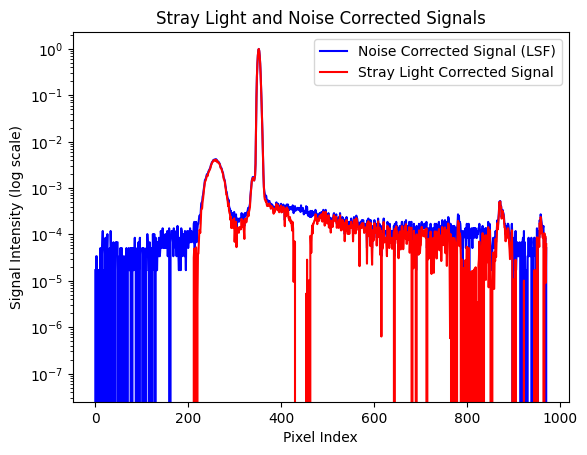

In [17]:


# Calculate the stray light corrected signal
result = np.dot(inverse, LSF[404-52])

# Plot the noise corrected signal
plt.plot(LSF[404-52], label='Noise Corrected Signal (LSF)', color='blue')

# Plot the stray light corrected signal
plt.plot(result, label='Stray Light Corrected Signal', color='red')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Add labels and title for clarity
plt.xlabel('Pixel Index')
plt.ylabel('Signal Intensity (log scale)')
plt.title('Stray Light and Noise Corrected Signals')

# Add a legend to differentiate between the plots
plt.legend()

# Display the plot
plt.show()


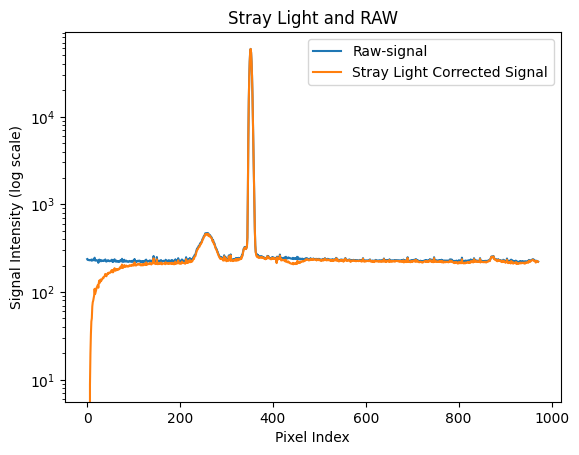

In [18]:

# Calculate the stray light corrected signal
result = np.dot(inverse, data_arry_Light[29][52:])
# Plot the noise corrected signal
plt.plot(data_arry_Light[29][52:], label='Raw-signal')
# Plot the stray light corrected signal
plt.plot(result, label='Stray Light Corrected Signal')
plt.yscale('log')
# Add labels and title for clarity
plt.xlabel('Pixel Index')
plt.ylabel('Signal Intensity (log scale)')
plt.title('Stray Light and RAW')
# Add a legend to differentiate between the plots
plt.legend()
# Display the plot
plt.show()


In [19]:

with open("laser_632.8_2.csv","r") as f:
    reader=csv.reader(f)
    data=list(reader)
laster_Value=np.array(data,dtype=float)
with open("laser_Dark_632.8_2.csv","r") as f:
    reader=csv.reader(f)
    data=list(reader)
Dark_VALU=np.array(data,dtype=float)


122.80420033633708


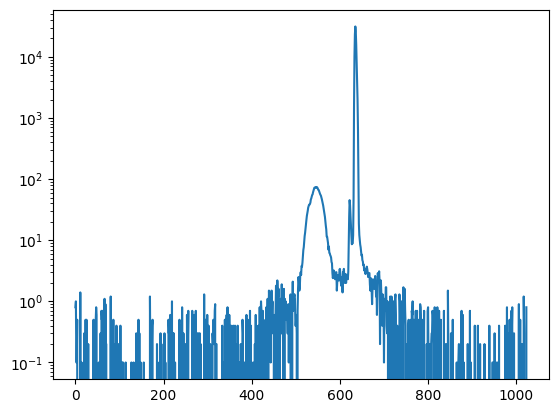

In [20]:
plt.plot(laster_Value[0]-Dark_VALU[0])
rms = np.sqrt(np.mean(laster_Value[0]-Dark_VALU[0]))**2
print(rms)
laster_Value[0]-Dark_VALU[0]
plt.yscale('log')

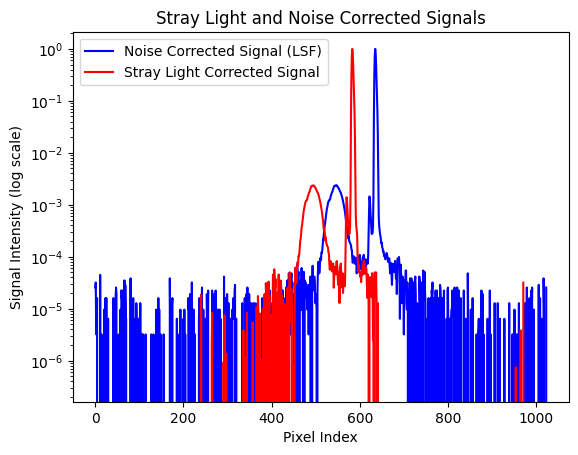

In [21]:

stray_light_value =  (((laster_Value[0] - R0) / 0.24) - ((Dark_VALU[0] - R0) /0.24))
stray_light_value=stray_light_value/(np.max(stray_light_value[52:]))

result = np.dot(inverse,stray_light_value[:][52:])

# Plot the noise corrected signal
plt.plot(stray_light_value, label='Noise Corrected Signal (LSF)', color='blue')

# Plot the stray light corrected signal
plt.plot(result, label='Stray Light Corrected Signal', color='red')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Add labels and title for clarity
plt.xlabel('Pixel Index')
plt.ylabel('Signal Intensity (log scale)')
plt.title('Stray Light and Noise Corrected Signals')

# Add a legend to differentiate between the plots
plt.legend()

# Display the plot
plt.show()
